In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib inline

# read in arealstatistik land cover data and drop unnecessary columns
folder_as = 'data/arealstatistik/'
df = pd.read_csv(f'{folder_as}AREA_Interpretationsresultate.csv', nrows=5000000)
df = df[['X_COORD','Y_COORD','FJ4','LC4_27','LC4_6']]
df = df.rename(columns={'X_COORD':'X', 'Y_COORD':'Y'})
df = df.dropna(axis=0,how='any')

print(df.shape)
# 2709450
df.head()

(2709450, 5)


,X,Y,FJ4,LC4_27,LC4_6
0,488900,112700,2012.0,11.0,10.0
1,489000,111400,2012.0,47.0,40.0
2,490700,116700,2012.0,11.0,10.0
3,491100,114500,2012.0,21.0,20.0
4,491200,117800,2012.0,46.0,40.0


In [2]:
# remap land cover according to remap dictionaries

# remap function
def remap(row):
    
    remap_dict1 = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4}
    remap_dict2 = {61: 5, 62: 6, 63: 1, 64: 1}
    
    # everything but 'watery areas' (60) is simply remapped
    if row['LC4_6'] == 60: # watery areas
        return remap_dict2.get(int(row['LC4_27']))  
    else: # non watery areas
        return remap_dict1.get(int(row['LC4_6']))
    # end of remap function


# apply function to data frame
df['land_cover'] = df.apply(remap, axis=1)
df.head()

,X,Y,FJ4,LC4_27,LC4_6,land_cover
0,488900,112700,2012.0,11.0,10.0,0
1,489000,111400,2012.0,47.0,40.0,3
2,490700,116700,2012.0,11.0,10.0,0
3,491100,114500,2012.0,21.0,20.0,1
4,491200,117800,2012.0,46.0,40.0,3


In [3]:
# convert data frame to a numpy array

# get indices based on coordinates
x_min = df['X'].min(); y_min = df['Y'].min()
x_max = df['X'].max(); y_max = df['Y'].max()
df['ix'] = (df['X'] - x_min)//100; df['iy'] = (df['Y'] - y_min)//100

# create numpy array

# indices start with 0 => +1 to get number of elemements
n_columns = df['ix'].max()+1; n_rows = df['iy'].max()+1

# [n rows, n columns]
land_cover = np.full((n_rows,n_columns),-1,dtype=int)
year = np.full((n_rows,n_columns),-1,dtype=int)
neighbour = np.full((n_rows,n_columns),-1,dtype=int)
print('shape:',land_cover.shape)

# transfer data frame data to array
for index, row in df.iterrows():
    
    land_cover[int(row['iy']),int(row['ix'])] = int(row['land_cover'])
    year[int(row['iy']),int(row['ix'])] = int(row['FJ4'])
    
    if index%1000000 == 0: print(index)
    # end of loop
    
# flip numpy array upside-down
land_cover = np.flip(land_cover,axis=0)
year = np.flip(year,axis=0)
neighbour = np.flip(neighbour,axis=0)

shape: (1863, 2833)
0
2000000
3000000


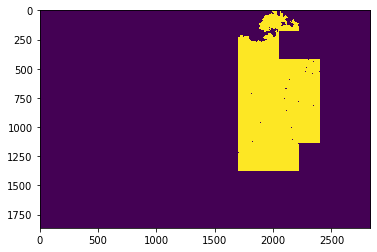

In [4]:
# display results
plt.imshow(land_cover)
plt.imshow(year==2016)

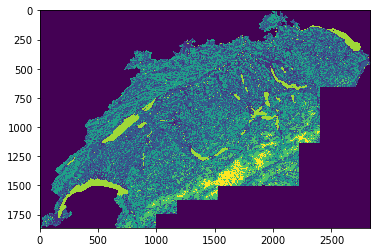

In [5]:
# interpolating missing values
# using the most frequent land cover in the 3x3 neighborhood

def adjacent_class_counts(kernel):
    
    assert(kernel.shape==(3,3))
    
    class_counts = {}
    for index, _ in np.ndenumerate(kernel):
        irow, icol = index
        if irow != 1 or icol!= 1:
            class_ = int(kernel[index[0],index[1]])
            count = class_counts.get(class_,0)
            class_counts[class_] = count + 1
    
    return class_counts

def interpolate(image):
     
    offset = 1
    new_image = np.copy(image)
    
    # loop over all pixels ignoring edges
    for i in range(offset,image.shape[0]-offset):
        for j in range(offset,image.shape[1]-offset):
            class_ = int(image[i,j])
            
            if class_ == -1:
                kernel = image[i-offset:i+offset+1,j-offset:j+offset+1]
                class_counts = adjacent_class_counts(kernel)
                n_nodata = class_counts.get(-1,0)
                if n_nodata == 0:
                    class_interp = max(class_counts, key=class_counts.get)
                    new_image[i,j] = class_interp
               
    return new_image


land_cover_interp = interpolate(land_cover)
plt.imshow(land_cover_interp)


datacube = np.full((n_rows,n_columns,3),-1,dtype=int)
datacube[:,:,0] = land_cover
datacube[:,:,1] = land_cover_interp
datacube[:,:,2] = year

band_names = ['land cover','land cover interp','flight year']


# export array as geo tiff file
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

# function to export a numpy array (arr) as geo tiff
def export_geotiff(fname, arr, x_min, y_max, x_res, y_res, crs, band_names):
    
    n_rows, n_cols, n_bands = np.shape(arr)
    
    geotransform = (x_min-50, x_res, 0, y_max+50, 0, -y_res)
    
    # open geo tiff file
    geotiff = gdal.GetDriverByName('GTiff').Create(fname+'.tif',n_cols, n_rows, n_bands, gdal.GDT_Int16)
    geotiff.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr. SpatialReference()
    srs.ImportFromEPSG(crs)
    geotiff.SetProjection(srs.ExportToWkt())
    
    # write array to geo tiff
    for iband in range(n_bands):
        raster_band = geotiff.GetRasterBand(iband+1)
        raster_band.WriteArray(arr[:,:,iband])
        raster_band.SetDescription(band_names[iband])
        raster_band.FlushCache()
    
    # end of export geo tiff function


export_geotiff(f'{folder_as}arealstatistik_landcover_2013',datacube,x_min,y_max,100,100,21781,band_names)

In [6]:
# function to determine whether array at given position is homogeneous
def get_n_same_neighbours(array,i_row,i_column):
    
    land_cover_center = array[i_row,i_column]
    
    if land_cover_center == -1:
        return land_cover_center
    else:
        values = []
        for x in range(i_row-1,i_row+2):
            for y in range(i_column-1,i_column+2):
                values.append(array[x,y])
    
        return values.count(land_cover_center)
        # end of else
        
    # end of function

x_coord_column = []
y_coord_column = []
land_cover_column = []
flight_year_column = []
n_neighbours_column = []

# (index row, index column)
for index, x in np.ndenumerate(land_cover):
    
    i_row = index[0]; i_column = index[1]
    
    n_neighbours = -1
    # get number of neighbours but ingore edges of matrix (for edges n_neighbours stays -1)
    if ((i_row>0 and i_row<n_rows-1) and (i_column>0 and i_column<n_columns-1)):
        n_neighbours = get_n_same_neighbours(land_cover,i_row,i_column)

    # only consider non-edges and points with data
    if x != -1:
        x_coord_column.append(int(i_column*100+x_min))
        y_coord_column.append(int(i_row*100+y_min))
        land_cover_column.append(x)
        flight_year_column.append(year[i_row,i_column])
        n_neighbours_column.append(n_neighbours)
        
        neighbour[i_row,i_column] = n_neighbours
    
    if i_column == 0 and i_row%100 == 0: print(index)
    # end of loop


data = {
    'X': x_coord_column,
    'Y': y_coord_column[::-1],
    'land_cover': land_cover_column,
    'FJ13': flight_year_column,
    'n_neigh': n_neighbours_column
}


data_df = pd.DataFrame(data,columns=['X','Y','land_cover','FJ13','n_neigh'])

# export as csv data frame
output_folder = 'data/arealstatistik/'
data_df.to_csv(f'{output_folder}as2013_preprocessed.csv', encoding='utf-8', index=False)


(0, 0)
(100, 0)
(200, 0)
(300, 0)
(400, 0)
(500, 0)
(600, 0)
(700, 0)
(800, 0)
(900, 0)
(1000, 0)
(1100, 0)
(1200, 0)
(1300, 0)
(1400, 0)
(1500, 0)
(1600, 0)
(1700, 0)
(1800, 0)


In [7]:


# export as shape file

import geopandas as gpd
from shapely.geometry import Point

# combine x and y column to a shapely Point() object
data_df['geometry'] = data_df.apply(lambda x: Point((float(x.X), float(x.Y))), axis=1)

# creating geo data frame and changing the crs to utm zone N32
gdf = gpd.GeoDataFrame(data_df, geometry='geometry')
gdf.crs = {'init': 'epsg:21781'}
# UTM Zone 32N: epsg:32632, WG84: epsg:4326
# gdf = gdf.to_crs({'init': 'epsg:4326'})

# exporting geo data frame as shapefile
gdf.to_file(f'{output_folder}as2013_reference_data.shp', driver='ESRI Shapefile')

In [8]:
# get coordinates
x_min, x_max, y_min, y_max = (df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max())
n_rows, n_cols = np.shape(land_cover)
x_res, y_res = (100, 100)
geotransform = (x_min-50, x_res, 0, y_max+50, 0, -y_res)

print(x_min, x_max)
print(y_min, y_max)

485500 768700
109700 295900


In [9]:
# export array as geo tiff file

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

# function to export a numpy array (arr) as geo tiff
def export_geotiff(arr, x_min, y_max, x_res, y_res, file_name):
    
    n_rows, n_cols = np.shape(arr)
    
    geotransform = (x_min-50, x_res, 0, y_max+50, 0, -y_res)
    
    # open geo tiff file
    output_raster = gdal.GetDriverByName('GTiff').Create(file_name+'.tif',n_cols, n_rows, 1, gdal.GDT_Int16)
    output_raster.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr. SpatialReference()
    srs.ImportFromEPSG(21781)
    output_raster.SetProjection(srs.ExportToWkt())
    
    # write array to geo tiff
    output_raster.GetRasterBand(1).WriteArray(arr)
    output_raster.FlushCache()
    
    # end of export geo tiff function

    
# export_geotiff(land_cover,x_min,y_max,100,100,'testtest')
    

In [10]:
x_min, x_max = [485500, 833800]
y_min, y_max = [75300, 295900]


# create region of interests
def getX_index(x_coord):
    return int((x_coord-x_min)/100)

def getY_index(y_coord):    
    return int((y_max-y_min)/100-(y_coord-y_min)/100)

def getX_coord(x_index):
    return int(x_index*100+x_min)

def getY_coord(y_index):
    return int((y_min+y_max)-(y_index*100+y_min))

print(getX_coord(getX_index(x_min)))
print(getX_coord(getX_index(x_max)))

print(getY_coord(getY_index(y_min)))
print(getY_coord(getY_index(y_max)))


485500
833800
75300
295900


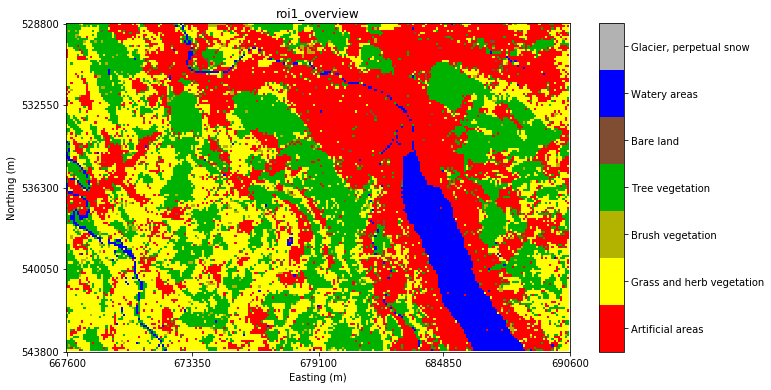

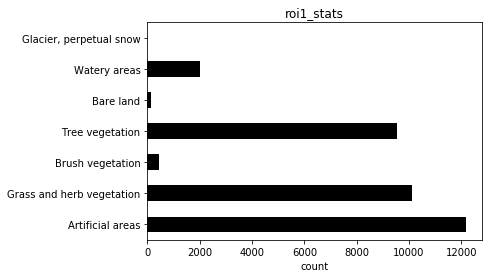

{2016: 34439, -1: 61}


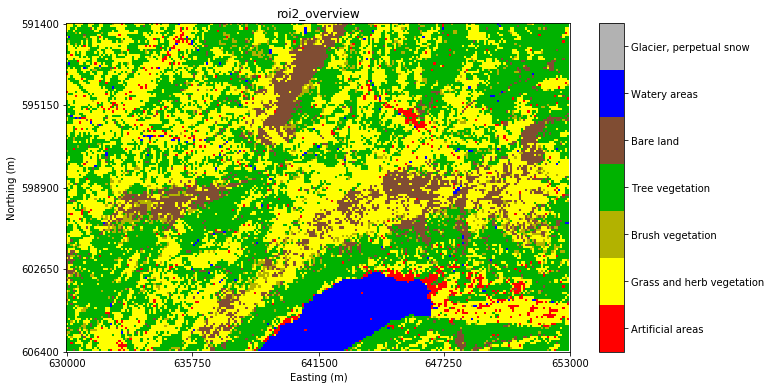

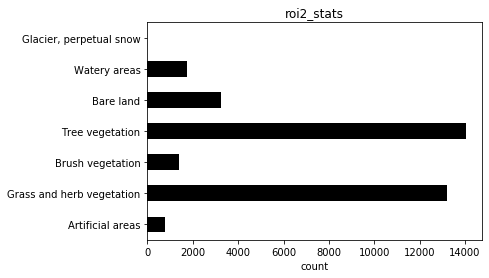

{-1: 69, 2015: 34431}


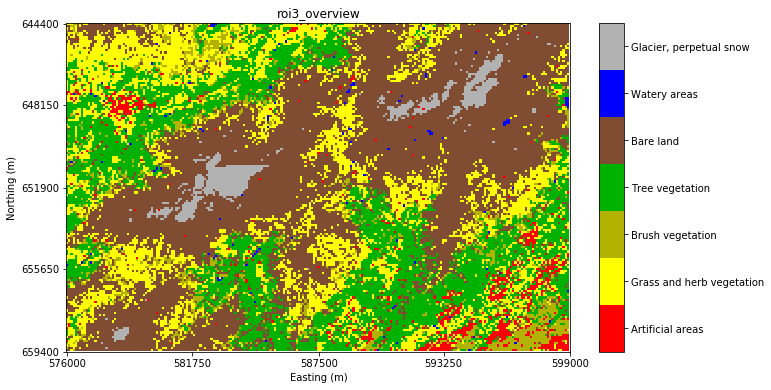

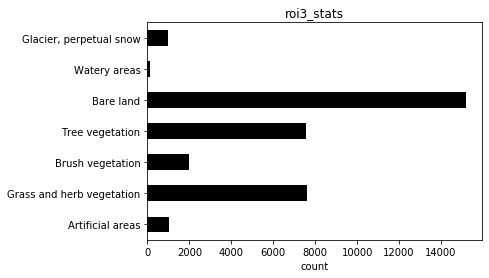

{2013: 34429, -1: 71}


In [11]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import random
from matplotlib import pyplot as plt


# width and height of a region of interest
roi_width = 230
roi_height = 150

# coordinates of the top left point of a region of interest
tl_coords_roi1 = (667600, 252600)
tl_coords_roi2 = (630000, 190000)
# tl_coords_roi3 = (580800, 108800)
tl_coords_roi3 = (665000, 180000)
tl_coords_roi3 = (576000, 137000)

tl_indices_roi1 = (getX_index(tl_coords_roi1[0]),getY_index(tl_coords_roi1[1]))
tl_indices_roi2 = (getX_index(tl_coords_roi2[0]),getY_index(tl_coords_roi2[1]))
tl_indices_roi3 = (getX_index(tl_coords_roi3[0]),getY_index(tl_coords_roi3[1]))


def plot_roi(arr,tl_indices,width,height,fig_name='roi'):
    
    classes = ['No data', 'Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
    hex_colors = ['#FFFFFF',"#FF0000","#FFFF00","#B2B200","#00B200","#804D33",'#0000FF','#B2B2B2']
    cmap = mpl.colors.ListedColormap(hex_colors[1:])
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,7), cmap.N)
        
    roi = arr[tl_indices[1]:tl_indices[1]+height,tl_indices[0]:tl_indices[0]+width]
        
    fig, ax = plt.subplots(figsize=(10,10))        
    im = ax.imshow(roi, cmap=cmap, norm=norm)

    x_indices = np.linspace(tl_indices[0],tl_indices[0]+width,5)
    x_ticks = [int(x-tl_indices[0]) for x in x_indices]
    plt.xticks(x_ticks,[getX_coord(x_index) for x_index in x_indices])

    y_indices = np.linspace(tl_indices[1],tl_indices[1]+height,5)
    y_ticks = [int(y-tl_indices[1]) for y in y_indices]
    plt.yticks(y_ticks,[getX_coord(y_index) for y_index in y_indices])

    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title(fig_name)

    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,7,8))
    cbar.ax.set_yticklabels(classes[1:])

    plt.savefig(fig_name+'.png',dpi=300)
    plt.show()

    # end of plot roi function
    
def stats_roi(arr,tl_indices,width,height,fig_name='roi'):
    
    data = arr[tl_indices[1]:tl_indices[1]+height,tl_indices[0]:tl_indices[0]+width]
    data_hist = data.flatten().tolist()
    # print(data_hist.count(6))
    bins = np.arange(-0.5, 7.5, 1) # fixed bin size
    classes = ['No data', 'Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
    plt.ylim([-0.5, 6.5])


    plt.hist(data_hist, bins=bins, color='k', rwidth=0.5,orientation='horizontal')
    plt.title(fig_name)
    plt.xlabel('count')
    plt.yticks(np.arange(0,7,1),classes[1:])

    plt.show()
    
    # end of roi stats function
    
    
def check_flight_year(arr,tl_indices,width,height):
    
    data = arr[tl_indices[1]:tl_indices[1]+height,tl_indices[0]:tl_indices[0]+width]
    data_hist = data.flatten().tolist()
    
    unique_values = list(set(data_hist))
    hist = {}
    for value in unique_values:
        hist[value] = data_hist.count(value)
    
    return hist
    # end of check flight year function
    
# roi 1
plot_roi(land_cover,tl_indices_roi1,roi_width,roi_height,'roi1_overview')
stats_roi(land_cover,tl_indices_roi1,roi_width,roi_height,'roi1_stats')

print(check_flight_year(year,tl_indices_roi1,roi_width,roi_height))

# roi 2
plot_roi(land_cover,tl_indices_roi2,roi_width,roi_height,'roi2_overview')
stats_roi(land_cover,tl_indices_roi2,roi_width,roi_height,'roi2_stats')

print(check_flight_year(year,tl_indices_roi2,roi_width,roi_height))

# roi 3
plot_roi(land_cover,tl_indices_roi3,roi_width,roi_height,'roi3_overview')
stats_roi(land_cover,tl_indices_roi3,roi_width,roi_height,'roi3_stats')

print(check_flight_year(year,tl_indices_roi3,roi_width,roi_height))

In [12]:
# exporting regions of interest as shape files and geo tiffs

import geopandas as gpd
from shapely.geometry import Point, Polygon



def convert_to_polygon(tl_coords, width, height):
    
    tl_x, tl_y = (tl_coords[0]-50, tl_coords[1]+50)
    lr_x = getX_coord(getX_index(tl_x)+width)+50
    lr_y = getY_coord(getY_index(tl_y)+height)-50
    
    tl = Point((float(tl_x),float(tl_y)))
    tr = Point((float(lr_x),float(tl_y)))
    lr = Point((float(lr_x),float(lr_y)))
    ll = Point((float(tl_x),float(lr_y)))
                      
    polygon = Polygon([[p.x,p.y] for p in [tl,tr,lr,ll]])
    print(polygon.wkt)
    
    return polygon


# function to export a region of interest as shape file
def export_shapefile(polygon, file_name):
    
    output_gdf = gpd.GeoDataFrame(pd.DataFrame({'geometry':[polygon]}), geometry='geometry')
    output_gdf.crs = {'init': 'epsg:21781'}
    # output_gdf = output_gdf.to_crs({'init': 'epsg:32632'})
    
    output_gdf.to_file(file_name+'.shp', driver='ESRI Shapefile')
    # end of export shape file function


# roi 1

polygon_roi1 = convert_to_polygon(tl_coords_roi1,roi_width,roi_height)
export_shapefile(polygon_roi1,'data/arealstatistik/roi1')

fname_roi1 = 'data/arealstatistik/validation_roi1_as2013'
land_cover_roi1 = land_cover[tl_indices_roi1[1]:tl_indices_roi1[1]+roi_height,tl_indices_roi1[0]:tl_indices_roi1[0]+roi_width]
export_geotiff(land_cover_roi1,tl_coords_roi1[0],tl_coords_roi1[1],100,100,fname_roi1)

# roi 2

polygon_roi2 = convert_to_polygon(tl_coords_roi2,roi_width,roi_height)
export_shapefile(polygon_roi2,'data/arealstatistik/roi2')

fname_roi2 = 'data/arealstatistik/validation_roi2_as2013'
land_cover_roi2 = land_cover[tl_indices_roi2[1]:tl_indices_roi2[1]+roi_height,tl_indices_roi2[0]:tl_indices_roi2[0]+roi_width]
export_geotiff(land_cover_roi2,tl_coords_roi2[0],tl_coords_roi2[1],100,100,fname_roi2)

# roi 3

polygon_roi3 = convert_to_polygon(tl_coords_roi3,roi_width,roi_height)
export_shapefile(polygon_roi3,'data/arealstatistik/roi3')

fname_roi3 = 'data/arealstatistik/validation_roi3_as2013'
land_cover_roi3 = land_cover[tl_indices_roi3[1]:tl_indices_roi3[1]+roi_height,tl_indices_roi3[0]:tl_indices_roi3[0]+roi_width]
export_geotiff(land_cover_roi3,tl_coords_roi3[0],tl_coords_roi3[1],100,100,fname_roi3)

POLYGON ((667550 252650, 690550 252650, 690550 237650, 667550 237650, 667550 252650))
POLYGON ((629950 190050, 652950 190050, 652950 175050, 629950 175050, 629950 190050))
POLYGON ((575950 137050, 598950 137050, 598950 122050, 575950 122050, 575950 137050))


In [13]:
folder_as = 'data/arealstatistik/'
df = pd.read_csv(f'{folder_as}as2013_preprocessed.csv')
df.head()




,X,Y,land_cover,FJ13,n_neigh
0,684600,295900,3,2016,-1
1,684600,295800,3,2016,4
2,684500,295800,3,2016,6
3,684600,295800,3,2016,6
4,684700,295700,2,2016,1


In [14]:
# combine x and y column to a shapely Point() object
df_roi1 = df
df_roi1['roi1'] = df.apply(lambda x: polygon_roi1.contains(Point((float(x.X), float(x.Y)))), axis=1)
df_roi1 = df_roi1[df_roi1['roi1']==True]
df_roi1 = df_roi1.drop(columns=['roi1'])
df_roi1.to_csv('roi1_as2013_prerpocessed.csv', encoding='utf-8', index=False)

# combine x and y column to a shapely Point() object
df_roi2['roi2'] = df.apply(lambda x: polygon_roi2.contains(Point((float(x.X), float(x.Y)))), axis=1)
df_roi2 = df_roi2[df_roi2['roi2']==True]
df_roi2 = df_roi2.drop(columns=['roi2'])
df_roi2.to_csv('roi2_as2013_prerpocessed.csv', encoding='utf-8', index=False)

# combine x and y column to a shapely Point() object
df_roi3['roi3'] = df.apply(lambda x: polygon_roi3.contains(Point((float(x.X), float(x.Y)))), axis=1)
df_roi3 = df_roi3[df_roi3['roi3']==True]
df_roi3 = df_roi3.drop(columns=['roi3'])
df_roi3.to_csv('roi3_as2013_prerpocessed.csv', encoding='utf-8', index=False)


NameError: name 'df_roi1' is not defined